# Stock Trading Bot using Reinforcement Learning

## Построение торгового бота на фондовом рынке с использованием обучения с подкреплением (Deep Q-Learning)

### Требования

Вы можете использовать **Google Colab с поддержкой GPU** для этого проекта. Однако, если вы хотите запускать его локально, вам потребуется установить следующие компоненты:

- **Python 3**
TORCH
- **Numpy**
- **Pandas**
- **Matplotlib**
- **Scikit-learn**


## Necessary Imports

In [1]:
import numpy as np
import pandas as pd
import torch
from datetime import datetime
import itertools
import argparse
import re
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline 
from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
torch.cuda.is_available()

True

## Import Dataset

In [3]:
def get_data():
    df = pd.read_csv('stock_data.csv')
    return df.values

In [4]:
df = pd.read_csv('stock_data.csv')
df.head()

,AAPL,MSI,SBUX
0,67.8542,60.30,28.185
1,68.5614,60.90,28.070
2,66.8428,60.83,28.130
3,66.7156,60.81,27.915
4,66.6556,61.12,27.775


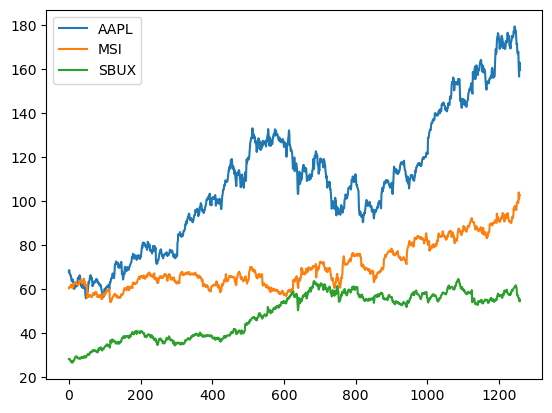

In [5]:
df.plot()
plt.show()

## Среда (Environment)

  * Определим среду для агента.  
  * Рассматриваем N акций  
  * Состояние: (кол-во акций, цены акций, кэш)  
  * Действия: (продать, купить, удерживать)  
  * Для 3 акций — 3^3 действий. Для N акций — 3^N, что не масштабируется.  
  * Награда — это просто изменение стоимости портфеля  
  >                              Стоимость портфеля = кол-во акций × цена + кэш


![](https://pytorch.org/tutorials/_images/reinforcement_learning_diagram.jpg)

## Архитектура обучения 

### Training Loop (Основной цикл обучения)
1. Выбрать действие: случайное или по policy-сети
2. Получить переход (s, a, r, s') из среды
3. Сохранить переход в буфер `Replay Memory`
4. Провести оптимизацию (обновление policy-сети)
5. Обновить `Target Net` (мягкое копирование из policy-сети)

---

### Компоненты:

- **Replay Memory**  
  Хранит переходы (опыт). Используется для случайного семплирования мини-батчей при обучении.

- **Policy Net**  
  Главная Q-сеть, которая используется для выбора действия.

- **Target Net**  
  Копия policy-сети, обновляется реже и используется для вычисления стабильной цели Q-обновления.

- **Optimize**  
  Шаг градиентного спуска: берём случайный батч из `Replay Memory`, вычисляем ошибку TD и обновляем веса `Policy Net`.

- **Update**  
  Мягкое обновление `Target Net`:


In [6]:
class MultiStockEnvironment:
    # Этот класс имитирует поведение среды в стиле OpenAI Gym
    # Он моделирует торговлю несколькими акциями на основе исторических данных

    def __init__(self, data, initial_investment=20000):
        """
        Параметры:
        - data: numpy-массив размерности (дни, акции) с историческими ценами
        - initial_investment: стартовая сумма денег
        """
        self.stock_price_history = data                        # исторические цены акций
        self.n_step, self.n_stock = self.stock_price_history.shape  # количество дней и количество акций

        self.initial_investment = initial_investment          # стартовый кэш
        self.cur_step = None                                  # текущий день
        self.stock_owned = None                               # вектор количества акций, которыми владеем
        self.stock_price = None                               # текущие цены акций
        self.cash_in_hand = None                              # сколько сейчас денег

        # Дискретное пространство действий: все комбинации (продать / держать / купить) для каждой акции
        self.action_space = np.arange(3**self.n_stock)        # например, для 3 акций — 9 действий

        # Перечень всех возможных векторов действий, например [0,2] → продать первую, купить вторую
        self.action_list = list(map(list, itertools.product([0, 1, 2], repeat=self.n_stock)))

        # Размер состояния: [владение акциями] + [цены] + [деньги]
        self.state_dim = self.n_stock * 2 + 1

        # Сброс на начальное состояние
        self.reset()

    def reset(self):
        """Сброс среды: устанавливает начальное состояние."""
        self.cur_step = 0
        self.stock_owned = np.zeros(self.n_stock)                     # ничего не куплено
        self.stock_price = self.stock_price_history[self.cur_step]   # начальные цены
        self.cash_in_hand = self.initial_investment                  # стартовые деньги
        return self._get_obs()

    def step(self, action):
        """
        Выполнить действие (торговую операцию), перейти к следующему состоянию,
        вернуть (новое состояние, награду, done-флаг, info)

        Аргумент:
        - action: индекс действия из action_space
        """
        assert action in self.action_space                           # проверка корректности действия

        prev_val = self._get_val()                                   # стоимость портфеля до сделки

        self.cur_step += 1                                           # следующий день
        self.stock_price = self.stock_price_history[self.cur_step]  # обновляем цены

        self._trade(action)                                          # совершаем торговлю

        cur_val = self._get_val()                                    # стоимость после сделки
        reward = cur_val - prev_val                                  # награда = изменение стоимости

        done = self.cur_step == self.n_step - 1                      # конец эпизода

        info = {'cur_val': cur_val}                                  # для отладки

        return self._get_obs(), reward, done, info

    def _get_obs(self):
        """Формирует и возвращает текущее наблюдение (состояние среды)."""
        obs = np.empty(self.state_dim)
        obs[:self.n_stock] = self.stock_owned                        # сколько акций куплено
        obs[self.n_stock:2*self.n_stock] = self.stock_price          # текущие цены
        obs[-1] = self.cash_in_hand                                  # текущий кэш
        return obs

    def _get_val(self):
        """Текущая стоимость портфеля: сумма стоимости акций + кэш."""
        return self.stock_owned.dot(self.stock_price) + self.cash_in_hand

    def _trade(self, action):
        """
        Совершает сделку на основе выбранного действия.

        Действия кодируются как:
        - 0: продать всю позицию по активу
        - 1: ничего не делать
        - 2: купить как можно больше акций
        """
        action_vector = self.action_list[action]

        # Определяем индексы акций, которые нужно продать и купить
        sell_index = []
        buy_index = []
        for i, a in enumerate(action_vector):
            if a == 0:
                sell_index.append(i)
            elif a == 2:
                buy_index.append(i)

        # Продажа всех доступных акций по текущей цене
        if sell_index:
            for i in sell_index:
                self.cash_in_hand += self.stock_price[i] * self.stock_owned[i]
                self.stock_owned[i] = 0

        # Покупка акций по одной, пока хватает кэша
        if buy_index:
            buy_me = True
            while buy_me:
                for i in buy_index:
                    if self.cash_in_hand >= self.stock_price[i]:
                        self.stock_owned[i] += 1
                        self.cash_in_hand -= self.stock_price[i]
                    else:
                        buy_me = False


Вот перевод текста в Markdown-формате:

---

## Буфер повторов (Replay Buffer)

* Буфер — это обычный список Python с фиксированным максимальным размером.
* Мы будем использовать структуру данных **циклической очереди** (Circular Queue).
* Каждый элемент буфера — это кортеж вида **(s, a, r, s', done)**.
* Новые кортежи добавляются в буфер по мере появления.
* Когда достигнут максимальный размер, необходимо удалить самый старый элемент.
  (В Python для этого по умолчанию используется `buffer.pop(0)` — операция "dequeue").

---

### Этапы реализации собственного буфера повторов:

* Предварительно выделить фиксированные массивы:

  * **States** — массив размерности (N × D)
  * **Actions** — массив длины N
  * **Rewards** — массив длины N
  * **Next States** — массив размерности (N × D)
  * **Done Flag** — массив длины N
    
  * N — это количество элементов, которые может хранить буфер. То есть максимальный размер буфера (например, buffer_size = 10000).
  * D — это размерность состояния (state). То есть длина вектора признаков, описывающих текущее состояние среды (например, [акции, цены, кэш] → размер D = 7, если 3 акции).

* Заполнять эти массивы по ходу обучения.

* Использовать указатель для определения позиции записи следующего элемента.

* Буфер будет **циклическим** — после достижения конца запись пойдёт с начала, заменяя старые значения.


![](https://wpumacay.github.io/research_blog/imgs/img_dqn_exp_replay_buffer.png)

In [7]:
class ReplayBuffer:
    def __init__(self, obs_dim, act_dim, size):
        """
        Буфер повторов (replay buffer), реализованный как циклический буфер фиксированного размера.

        Аргументы:
        - obs_dim (int): размерность состояния
        - act_dim (int): размерность действия (если дискретное — обычно 1)
        - size (int): максимальное количество переходов, которые может хранить буфер
        """
        # Предварительно выделяем память под массивы нужной размерности
        self.obs1_buf = np.zeros([size, obs_dim], dtype=np.float32)   # состояние s
        self.obs2_buf = np.zeros([size, obs_dim], dtype=np.float32)   # следующее состояние s'
        self.acts_buf = np.zeros(size, dtype=np.int64)                # действия a
        self.rews_buf = np.zeros(size, dtype=np.float32)              # награды r
        self.done_buf = np.zeros(size, dtype=np.uint8)                # флаг завершения done (0 или 1)

        self.ptr = 0          # указатель на текущую позицию записи
        self.size = 0         # фактическое количество элементов в буфере
        self.max_size = size  # максимальный размер буфера

    def store(self, obs, act, rew, next_obs, done):
        """
        Сохраняет один переход (s, a, r, s', done) в буфере.
        """
        self.obs1_buf[self.ptr] = obs
        self.obs2_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done

        # Увеличиваем указатель циклически
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self, batch_size=32):
        """
        Возвращает случайную мини-партию переходов (batch_size штук).
        """
        idxs = np.random.randint(0, self.size, size=batch_size)

        # Если ты будешь использовать это с PyTorch — нужно будет сделать to_tensor в агенте
        batch = dict(
            s1=self.obs1_buf[idxs],
            s2=self.obs2_buf[idxs],
            a=self.acts_buf[idxs],
            r=self.rews_buf[idxs],
            d=self.done_buf[idxs]
        )
        return batch


## Нейросетевая модель
Архитектура нейросети будет представлять собой многослойный персептрон (MLP), который агент будет использовать для регрессии, то есть для предсказания значений действий.



![title](../DQN.png)

### 🔁 Как обучается торговый агент (по шагам):

1. **Начало**
   Загружаются данные по акциям. Агент стартует с нуля акций и фиксированной суммой денег.

2. **Наблюдение**
   Агент смотрит на текущие цены, сколько у него акций, и сколько денег на руках.

3. **Принятие решения**
   На основе состояния нейросеть выбирает действие: купить, продать или держать.

4. **Взаимодействие с рынком**
   Агент выполняет действие, переходит к следующему дню и получает награду — изменение общей стоимости его активов.

5. **Сохранение опыта**
   Сохраняется (состояние, действие, награда, следующее состояние) в буфер.

6. **Обучение нейросети**
   Периодически из буфера берутся случайные примеры, и на их основе обновляются веса сети.

7. **Повтор**
   Повторяем шаги со 2 по 6 до конца данных. Затем начинается новый эпизод.

---

📌 *Цель*: найти такую стратегию действий, которая стабильно увеличивает стоимость портфеля.


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ActionNN(nn.Module):
    def __init__(self, input_dim, n_action, n_hidden_layers=2, hidden_dim=32):
        super(ActionNN, self).__init__()
        layers = []

        # Входной слой
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())

        # Скрытые слои
        for _ in range(n_hidden_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())

        # Выходной слой (предсказывает Q-значения для каждого действия)
        layers.append(nn.Linear(hidden_dim, n_action))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


## Agent

Согласно определению из области вычислительного интеллекта, агент — это нечто, что *воспринимает среду* с помощью сенсоров/данных и *влияет на неё* через актуаторы (действия).



In [9]:
class DQNAgent:
    def __init__(self, state_size, action_size, buffer_size=500, batch_size=32,
                 gamma=0.95, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995,
                 learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = ReplayBuffer(state_size, action_size, size=buffer_size)
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size

        self.model = ActionNN(state_size, action_size)
        self.optimizer = torch.optim.Adam(
            self.model.parameters(),
            lr=learning_rate,
            betas=(beta_1, beta_2),
            amsgrad=amsgrad
        )

    def update_replay_buffer(self, state, action, reward, next_state, done):
        self.memory.store(state, action, reward, next_state, done)

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = self.model(state_tensor)
        return torch.argmax(q_values).item()

    def replay(self):
        if self.memory.size < self.batch_size:
            return
        minibatch = self.memory.sample_batch(self.batch_size)
        states = torch.FloatTensor(minibatch['s1'])
        next_states = torch.FloatTensor(minibatch['s2'])
        actions = torch.LongTensor(minibatch['a'])
        rewards = torch.FloatTensor(minibatch['r'])
        dones = torch.BoolTensor(minibatch['d'])

        current_q = self.model(states).gather(1, actions.unsqueeze(1)).squeeze()
        with torch.no_grad():
            max_next_q = self.model(next_states).max(1)[0]
            target_q = rewards + (self.gamma * max_next_q * (~dones))

        loss = F.mse_loss(current_q, target_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def save(self, path):
        torch.save(self.model.state_dict(), path)

    def load(self, path):
        self.model.load_state_dict(torch.load(path))
        self.model.eval()




## Utility functions

* **`make_dir`** — создаёт директорию для сохранения модели и метрик (например, наград), если она ещё не существует.

* **`plot_rewards`** — строит график наград, чтобы можно было проанализировать поведение агента на рынке акций.




In [10]:
def make_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

In [11]:
def plot_rewards(choice):
    a = np.load(f'{REWARDS_FOLDER}/{choice}.npy')

    print(f"Average Reward: {a.mean():.2f} | Min: {a.min():.2f} | Max: {a.max():.2f}")

    plt.hist(a, bins=30)
    plt.title(choice)
    # plt.show()



## Стандартизация / Нормализация

Значения в датасете могут находиться в диапазоне от 0 до бесконечности. Если большинство данных сосредоточено в области тысяч, десятков тысяч или миллионов, и мало значений рядом с нулём — это вызовет **смещение** (bias) при обучении и приведёт к плохой работе модели на входах, близких к нулю.

Поэтому необходимо масштабировать данные так, чтобы они были сосредоточены вокруг 0, например, привести значения к диапазону от 0 до 1 или от -1 до 1. После масштабирования значения будут следовать нормальному (гауссовскому) распределению, выбранному для стандартизации.

**Нормальное распределение:**

> Z = (X - μ) / σ

где
μ — среднее значение в выборке
σ — стандартное отклонение

**Стандартизированное нормальное распределение** — это частный случай нормального распределения с параметрами μ = 0 и σ = 1.

---



In [12]:
def get_scaler(env):
    # функция для стандартизации значений
    # возвращает объект стандартизатора (scaler) из scikit-learn для масштабирования состояний
    states = []
    for _ in range(env.n_step):
        action = np.random.choice(env.action_space)  # случайное действие
        state, reward, done, info = env.step(action) # совершаем шаг
        states.append(state)                         # сохраняем состояние
        if done:
            break

    scaler = StandardScaler()       # создаём объект стандартизатора
    scaler.fit(states)              # обучаем его на собранных состояниях
    return scaler                   # возвращаем объект для масштабирования




## Выполнение и обучение

Функция `play_one_episode` проигрывает один эпизод взаимодействия с окружением и параллельно обучает агента в течение этого эпизода.




In [13]:
def play_one_episode(agent, env, is_train, scaler, batch_size):
    state = env.reset()
    state = scaler.transform([state])
    state = torch.tensor(state, dtype=torch.float32)
    done = False
    total_reward = 0

    while not done:
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        next_state = scaler.transform([next_state])
        next_state = torch.tensor(next_state, dtype=torch.float32)

        if is_train == 'train':
            agent.update_replay_buffer(state, action, reward, next_state, done)
            agent.replay()

        state = next_state
        total_reward += reward

    return info['cur_val']

## Bot Main

Train and test the bot 

### Train

In [14]:
import os
import pickle
from datetime import datetime
from tqdm.notebook import trange, tqdm


# Гиперпараметры
MODELS_FOLDER = 'trader_models/'
REWARDS_FOLDER = 'trader_rewards/'
NUM_EPISODES = 100
BATCH_SIZE = 32
INITIAL_INVESTMENT = 50000
LEARNING_RATE = 0.001
BETA_1 = 0.9
BETA_2 = 0.999
AMSGRAD = False
EPSILON_START = 1.0
EPSILON_MIN = 0.01
EPSILON_DECAY = 0.995
GAMMA = 0.95

make_dir(MODELS_FOLDER)
make_dir(REWARDS_FOLDER)

data = get_data()
n_timesteps, n_stocks = data.shape
choice = 'train'
n_train = n_timesteps // 2
train_data = data[:n_train]
test_data = data[n_train:]

env = MultiStockEnvironment(train_data, INITIAL_INVESTMENT)
state_size = env.state_dim
action_size = len(env.action_space)

agent = DQNAgent(
    state_size, action_size,
    gamma=GAMMA,
    epsilon=EPSILON_START,
    epsilon_min=EPSILON_MIN,
    epsilon_decay=EPSILON_DECAY,
    learning_rate=LEARNING_RATE,
    beta_1=BETA_1,
    beta_2=BETA_2,
    amsgrad=AMSGRAD
)

scaler = get_scaler(env)
portfolio_value = []

if choice == 'test':
    with open(f'{MODELS_FOLDER}/standard_scaler.dat', 'rb') as f:
        scaler = pickle.load(f)
    env = MultiStockEnvironment(test_data, INITIAL_INVESTMENT)
    agent.epsilon = EPSILON_MIN
    agent.load(f'{MODELS_FOLDER}/nn_agent.pt')

for episode in trange(NUM_EPISODES, desc="Training episodes"):
    t0 = datetime.now()
    val = play_one_episode(agent, env, choice, scaler, BATCH_SIZE)
    dt = datetime.now() - t0
    tqdm.write(f"Episode {episode+1}/{NUM_EPISODES} | Final Portfolio Value: {val:.2f} | Duration: {dt}")
    portfolio_value.append(val)

if choice == 'train':
    agent.save(f'{MODELS_FOLDER}/nn_agent.pt')
    with open(f'{MODELS_FOLDER}/standard_scaler.dat', 'wb') as f:
        pickle.dump(scaler, f)
    with open(f'{REWARDS_FOLDER}/portfolio_values.pkl', 'wb') as f:
        pickle.dump(portfolio_value, f)


Training episodes:   0%|          | 0/100 [00:00<?, ?it/s]

Episode 1/100 | Final Portfolio Value: 100804.76 | Duration: 0:00:00.845826
Episode 2/100 | Final Portfolio Value: 102288.46 | Duration: 0:00:00.819070
Episode 3/100 | Final Portfolio Value: 60363.15 | Duration: 0:00:00.852450
Episode 4/100 | Final Portfolio Value: 67036.67 | Duration: 0:00:00.865234
Episode 5/100 | Final Portfolio Value: 59853.92 | Duration: 0:00:00.855533
Episode 6/100 | Final Portfolio Value: 68221.45 | Duration: 0:00:00.850180
Episode 7/100 | Final Portfolio Value: 86219.00 | Duration: 0:00:00.860465
Episode 8/100 | Final Portfolio Value: 64478.91 | Duration: 0:00:00.873417
Episode 9/100 | Final Portfolio Value: 82950.69 | Duration: 0:00:00.852238
Episode 10/100 | Final Portfolio Value: 86041.55 | Duration: 0:00:00.871596
Episode 11/100 | Final Portfolio Value: 91378.88 | Duration: 0:00:00.849736
Episode 12/100 | Final Portfolio Value: 83359.44 | Duration: 0:00:00.871930
Episode 13/100 | Final Portfolio Value: 101878.09 | Duration: 0:00:00.879575
Episode 14/100 | F

In [15]:
if choice == 'train':
    # сохранить веса модели PyTorch
    agent.save(f'{MODELS_FOLDER}/nn_agent.pt')

    # сохранить масштабировщик
    with open(f'{MODELS_FOLDER}/standard_scaler.dat', 'wb') as f:
        pickle.dump(scaler, f)

# сохранить значения портфеля по эпизодам
np.save(f'{REWARDS_FOLDER}/{choice}.npy', portfolio_value)

Average Reward: 97687.42 | Min: 54451.77 | Max: 156473.30


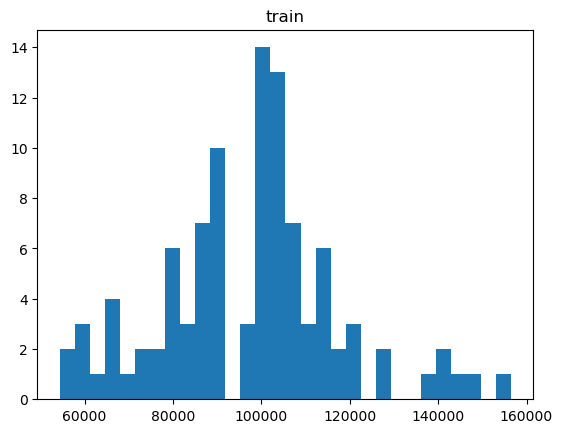

In [16]:
plot_rewards(choice)
plt.show()

Plot the rewards obtained during the training process

In [17]:
train_invest = np.load(f'{REWARDS_FOLDER}/train.npy')

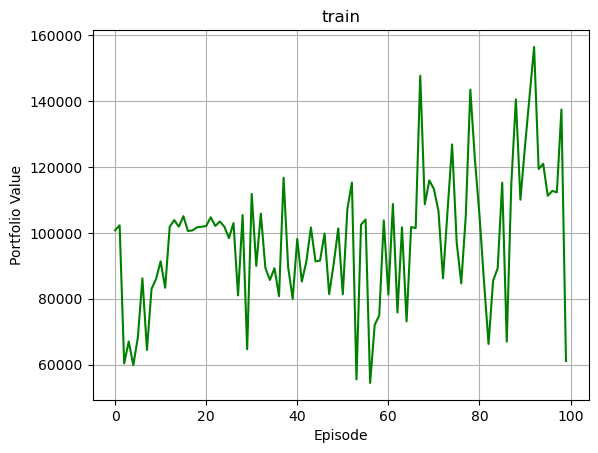

In [18]:
plt.plot(np.arange(len(train_invest)), train_invest, color='green')
plt.xlabel("Episode")
plt.ylabel("Portfolio Value")
plt.title("train")
plt.grid(True)
plt.show()

### Test

In [ ]:
import os
import numpy as np
import pickle
import torch
from datetime import datetime

# Гиперпараметры
NUM_EPISODES = 100
BATCH_SIZE = 32
INITIAL_INVESTMENT = 30000
MODELS_FOLDER = 'trader_models/'
REWARDS_FOLDER = 'trader_rewards/'
choice = 'test'

# Восстановим scaler и агентскую модель
with open(f'{MODELS_FOLDER}/standard_scaler.dat', 'rb') as f:
    scaler = pickle.load(f)

# Тестовая среда
env = MultiStockEnvironment(test_data, INITIAL_INVESTMENT)
state_size = env.state_dim
action_size = len(env.action_space)

agent = DQNAgent(state_size, action_size)
agent.epsilon = 0.01  # при инференсе - минимальная эпсилон
agent.load(f'{MODELS_FOLDER}/nn_agent.pt')  # ⚠️ расширение `.pt`, не `.h5`

# Подсчёт прибыли
portfolio_value = []

for e in range(NUM_EPISODES):
    t0 = datetime.now()
    val = play_one_episode(agent, env, is_train='test', scaler=scaler, batch_size=BATCH_SIZE)
    dt = datetime.now() - t0
    print(f"Episode {e+1}/{NUM_EPISODES} | Final Portfolio Value: {val:.2f} | Duration: {dt}")
    portfolio_value.append(val)

# Сохраняем результат
np.save(f'{REWARDS_FOLDER}/{choice}.npy', portfolio_value)

Episode 1/100 | Final Portfolio Value: 41480.57 | Duration: 0:00:00.121074
Episode 2/100 | Final Portfolio Value: 38149.83 | Duration: 0:00:00.121220
Episode 3/100 | Final Portfolio Value: 36114.32 | Duration: 0:00:00.118661
Episode 4/100 | Final Portfolio Value: 38362.20 | Duration: 0:00:00.118375
Episode 5/100 | Final Portfolio Value: 42042.71 | Duration: 0:00:00.119081
Episode 6/100 | Final Portfolio Value: 44381.10 | Duration: 0:00:00.120000
Episode 7/100 | Final Portfolio Value: 47029.57 | Duration: 0:00:00.120000
Episode 8/100 | Final Portfolio Value: 39465.67 | Duration: 0:00:00.110927
Episode 9/100 | Final Portfolio Value: 43725.46 | Duration: 0:00:00.124068
Episode 10/100 | Final Portfolio Value: 41009.42 | Duration: 0:00:00.115183
Episode 11/100 | Final Portfolio Value: 35054.90 | Duration: 0:00:00.118000
Episode 12/100 | Final Portfolio Value: 32869.25 | Duration: 0:00:00.118006
Episode 13/100 | Final Portfolio Value: 48207.92 | Duration: 0:00:00.120294
Episode 14/100 | Fina

In [ ]:
plot_rewards(choice)
plt.show()

Plot the rewards obtained during the testing process

In [ ]:
test_invest = np.load(f'{REWARDS_FOLDER}/test.npy')

In [ ]:
plt.plot(test_invest)
plt.show()

In [ ]:
plt.plot(np.arange(len(portfolio_value)), portfolio_value, color='green')
plt.xlabel("Episode")
plt.ylabel("Portfolio Value")
plt.title("test")
plt.grid(True)
plt.show()